This should be runned using the `carla-env`

In [1]:
import os
import sys
import importlib
import json

import pandas as pd
import carla
import matplotlib.pyplot as plt

# Add the "scripts" directory to sys.path
sys.path.append(os.path.abspath("../src"))
from sim import carla_utils

town = 'Town01'  # Use Town01_Opt for a lighter version of Town01

# Connecting to CARLA

CARLA must be running

In [2]:
# Connecting to CARLA
client = carla.Client('localhost', 2000)
client.set_timeout(40)
world = client.get_world()
world = client.load_world(f'{town}_Opt') # Town*_Opt is a lighter version with layers

world.unload_map_layer(carla.MapLayer.Foliage)
world.unload_map_layer(carla.MapLayer.Particles)
world.unload_map_layer(carla.MapLayer.Buildings)
world.unload_map_layer(carla.MapLayer.ParkedVehicles)
world.unload_map_layer(carla.MapLayer.StreetLights)

spectator = world.get_spectator()
spawn_points = world.get_map().get_spawn_points()

## Setting up sensors

### IMU settings

In [3]:
imu_bp = world.get_blueprint_library().find('sensor.other.imu')
carla_utils.set_attributes_imu(imu_bp)

### GNSS settings

In [4]:
gnss_bp = world.get_blueprint_library().find('sensor.other.gnss')
carla_utils.set_attributes_gnss(gnss_bp)

# Running the Simulations

CARLA uses to be very sensible to some routes and crash or soft lock for some of them. Make sure to test them before you collect the data.

Getting the routines generated files

In [5]:
routines_folder = f'../src/sim/llm_routines/{town}'
sps = carla_utils.get_spawn_points_from_csv(f'../src/sumo_map/{town}/interest_points.csv')
routine_files = os.listdir(routines_folder)

routines = []
for routine_file in routine_files:
    routine_csv = f'{routines_folder}/{routine_file}'
    df = pd.read_csv(routine_csv)
    routines.append(df)

print(f'{len(routines)} routines found')  # Number of routines generated
routines[0] # Display the first routine

# Setting up the routine spawn points
sps_routines = []
for routine in routines:
    locations = routine.location.values.tolist()
    sps_routines.append([sps[location] for location in locations])

10 routines found


Setting up the simulation parameters

In [6]:
vehicle_bp = world.get_blueprint_library().filter('vehicle.tesla.model3')[0]  # Get the first vehicle blueprint
simulation_params = {
    "vehicle_bp": vehicle_bp,
    "sensor_bps": [imu_bp, gnss_bp],
    "delta_time": 0.1, 
    "n_extra_vehicles": 10,
    "freeze_traffic_lights": True,    
    "fixed_spectator": True,
    "draw_debug_route": True,
    "render": False,
    "agent_params": None # Will be set later
}

## Fixed Parameters

In [7]:
fixed_params = json.load(open('../configs/carla_fixed.json', 'r'))
simulation_params['agent_params'] = fixed_params

### Fixed Parameters (no traffic)

In [13]:
simulation_params['n_extra_vehicles'] = 0  # No extra vehicles

try:
    carla_utils.run_simulation(
        client, 
        simulation_params, 
        sps_routines, 
        output_folder=f'../data/synthetic/{town}/carla/fixed/no_traffic', 
    )
except Exception as e:
    print(f"An error occurred: {e}")
    carla_utils.destroy_all_vehicles(client)


------------------ ROUTINE 0 - BEHAVIOR: normal ---------------------------

Freezing all traffic lights...
Delta time set to 0.1 seconds. Synchronous mode enabled.
Ego vehicle created with ID: 192
Spawning 2 sensors...
Spawned 2 sensors.
IMU sensor attached.
GNSS sensor attached.
Checkpoint reached!
Vehicle has reached the final destination.
Destroying all vehicles...
All actors destroyed.

------------------ VEHICLE veh_0_normal FINISHED ---------------------------


------------------ ROUTINE 0 - BEHAVIOR: aggressive ---------------------------

Freezing all traffic lights...
Delta time set to 0.1 seconds. Synchronous mode enabled.
Ego vehicle created with ID: 195
Spawning 2 sensors...
Spawned 2 sensors.
IMU sensor attached.
GNSS sensor attached.
Checkpoint reached!
Vehicle has reached the final destination.
Destroying all vehicles...
All actors destroyed.

------------------ VEHICLE veh_0_aggressive FINISHED ---------------------------

Simulation finished. All data saved to CSV f

### Fixed Parameters (traffic)

In [ ]:
try:
    carla_utils.run_simulation(
        client, 
        simulation_params, 
        sps_routines,
        output_folder=f'../data/synthetic/{town}/carla/fixed/traffic',
        use_dists=False,
    )
except Exception as e:
    print(f"An error occurred: {e}")
    carla_utils.destroy_all_vehicles(client)

Performing 10 routines for behavior: aggressive

------------------ VEHICLE veh_0_aggressive DEPARTED ---------------------------

Freezing all traffic lights...
Delta time set to 0.1 seconds. Synchronous mode enabled.
Ego vehicle created with ID: 192
Spawning 2 sensors...
Spawned 2 sensors.
IMU sensor attached.
GNSS sensor attached.
Spawned 10 vehicles with Traffic Manager
Checkpoint 1 reached!
Checkpoint 2 reached!
Checkpoint 3 reached!


: 

## LLM Parameters

Usually, it is a good idea to reopen CARLA and restart the python kernel after each simulation.

In [7]:
agent_params_llm_dists = json.load(open('../configs/carla_llm.json', 'r'))
# Now we must select one of the types of vehicle for each behavior (there might be multiple types for each behavior)
simulation_params['agent_params'] = agent_params_llm_dists

### LLM parameters (no traffic)

In [ ]:
simulation_params['n_extra_vehicles'] = 0  # No extra vehicles

try:
    carla_utils.run_simulation(
        client, 
        simulation_params, 
        sps_routines, 
        output_folder=f'../data/synthetic/{town}/carla/llm/no_traffic', 
    )
except Exception as e:
    print(f"An error occurred: {e}")
    carla_utils.destroy_all_vehicles(client)

### LLM parameters (traffic)

With the LLM parameters, we are able to do multiple runs varying the parameters

In [8]:
try:
    carla_utils.run_simulation(
        client, 
        simulation_params, 
        sps_routines, 
        use_dists=True,
        output_folder=f'../data/synthetic/{town}/carla/llm/traffic', 
    )
except Exception as e:
    print(f"An error occurred: {e}")
    carla_utils.destroy_all_vehicles(client)

Performing 10 routines for behavior: veh_normal

------------------ VEHICLE veh_0_normal DEPARTED ---------------------------

Using vehicle type: veh_normal0
Freezing all traffic lights...
Delta time set to 0.1 seconds. Synchronous mode enabled.
Ego vehicle created with ID: 192
Spawning 2 sensors...
Spawned 2 sensors.
IMU sensor attached.
GNSS sensor attached.
Spawned 10 vehicles with Traffic Manager
Checkpoint 1 reached!
Checkpoint 2 reached!
Checkpoint 3 reached!
Checkpoint 4 reached!
Checkpoint 5 reached!
Checkpoint 6 reached!
Checkpoint 7 reached!
Checkpoint 8 reached!
Checkpoint 9 reached!
Checkpoint 10 reached!
Vehicle has reached the final destination.
Destroying all vehicles...
All actors destroyed.

------------------ VEHICLE veh_0_normal FINISHED ---------------------------


------------------ VEHICLE veh_1_normal DEPARTED ---------------------------

Using vehicle type: veh_normal1
Freezing all traffic lights...
Delta time set to 0.1 seconds. Synchronous mode enabled.
Ego 

In [14]:
def plot_df(df, title, output_path):
    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    time_str = 'Time(s)'
    # Plot acc_x
    axs[0].plot(df['timestamp'], df['acc_x'], label='acc_x')
    axs[0].plot(df['timestamp'], df['acc_y'], label='acc_y', color='orange')
    axs[0].set_title('Acceleration over Time')
    axs[0].set_xlabel(time_str)
    axs[0].set_ylabel('acc (m/s²)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot gyro
    axs[1].plot(df['timestamp'], df['gyro_x'], label='gyro_x')
    axs[1].plot(df['timestamp'], df['gyro_y'], label='gyro_y', color='orange')
    axs[1].plot(df['timestamp'], df['gyro_z'], label='gyro_z', color='green')
    axs[1].set_title('Gyroscope over Time')
    axs[1].set_xlabel(time_str)
    axs[1].set_ylabel('gyro (rad/s)')
    axs[1].legend()
    axs[1].grid(True)

    # Plot latitude vs longitude, colored by time
    sc = axs[2].scatter(df['latitude'], df['longitude'], c=df['timestamp'], cmap='viridis', label='Trajectory')
    axs[2].set_title('Trajectory: Latitude vs Longitude (colored by time)')
    axs[2].set_xlabel('Latitude')
    axs[2].set_ylabel('Longitude')
    axs[2].grid(True)
    cbar = plt.colorbar(sc, ax=axs[2])
    cbar.set_label(time_str)

    plt.suptitle(title)
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
        print(f"Figure saved to {output_path}")

    plt.show()

Figure saved to ../results/figures/carla/Town01/aggressive_fixed.png


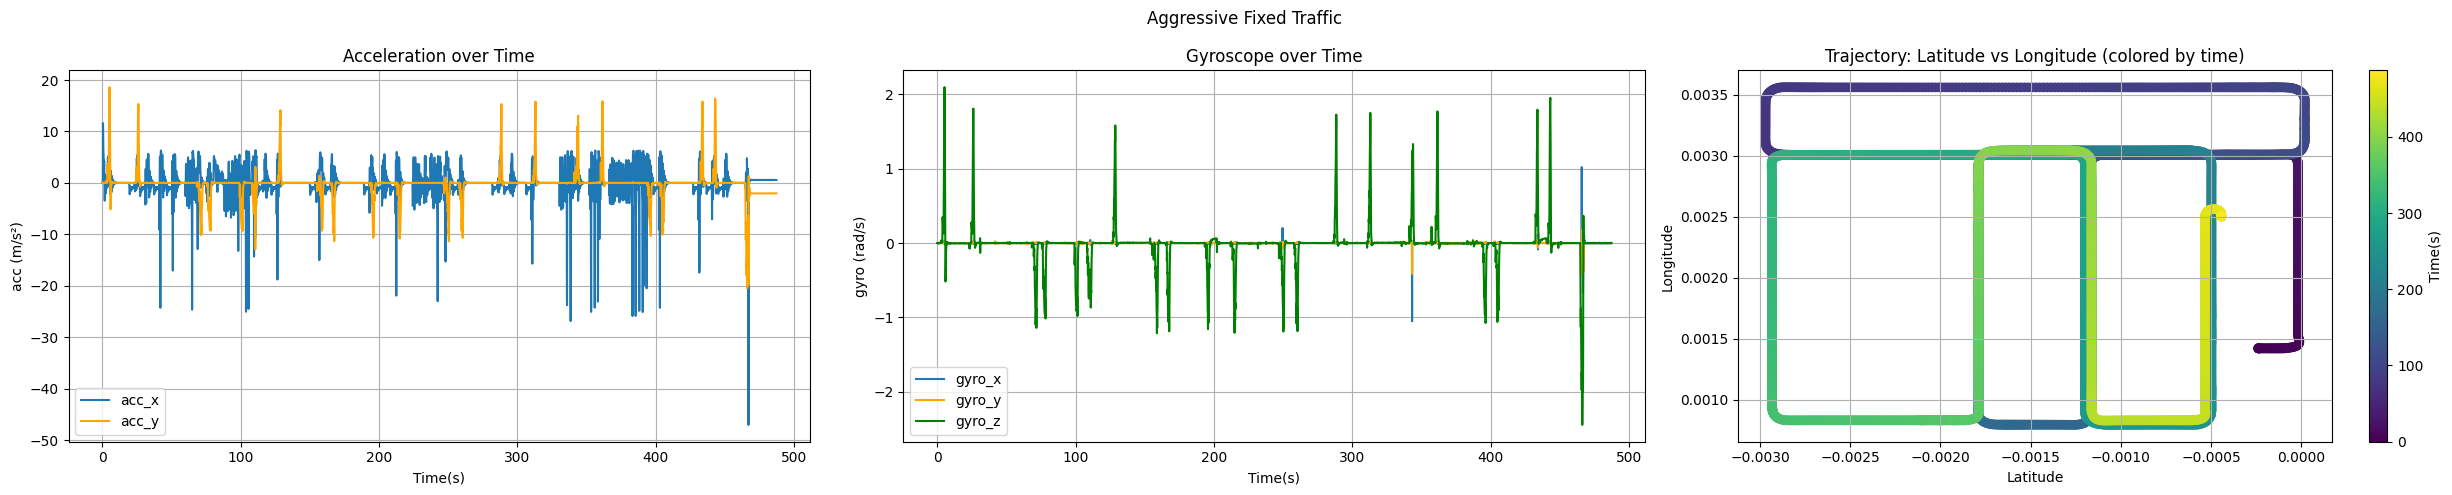

Figure saved to ../results/figures/carla/Town01/aggressive_llm.png


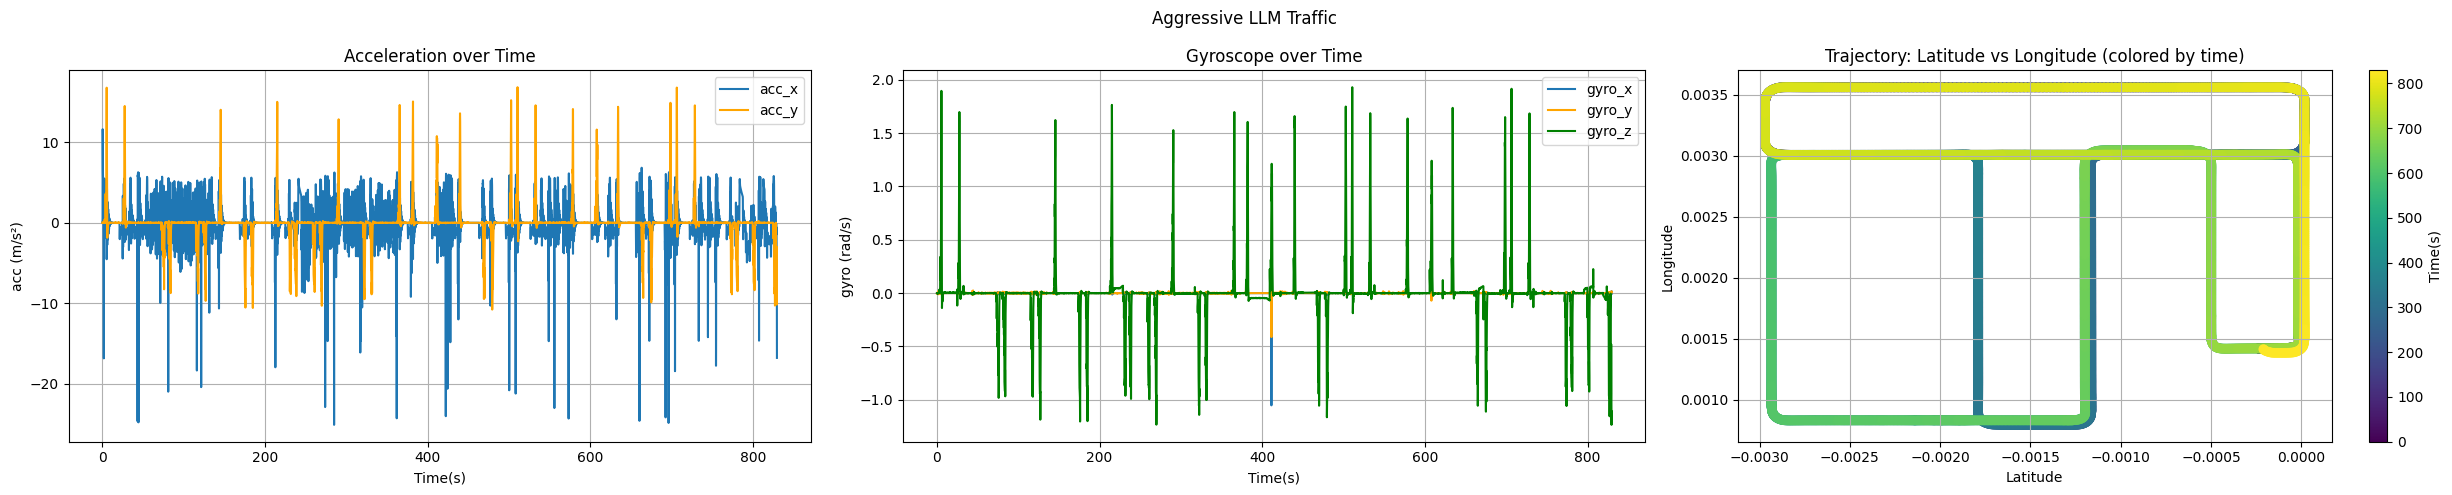

Figure saved to ../results/figures/carla/Town01/normal_fixed.png


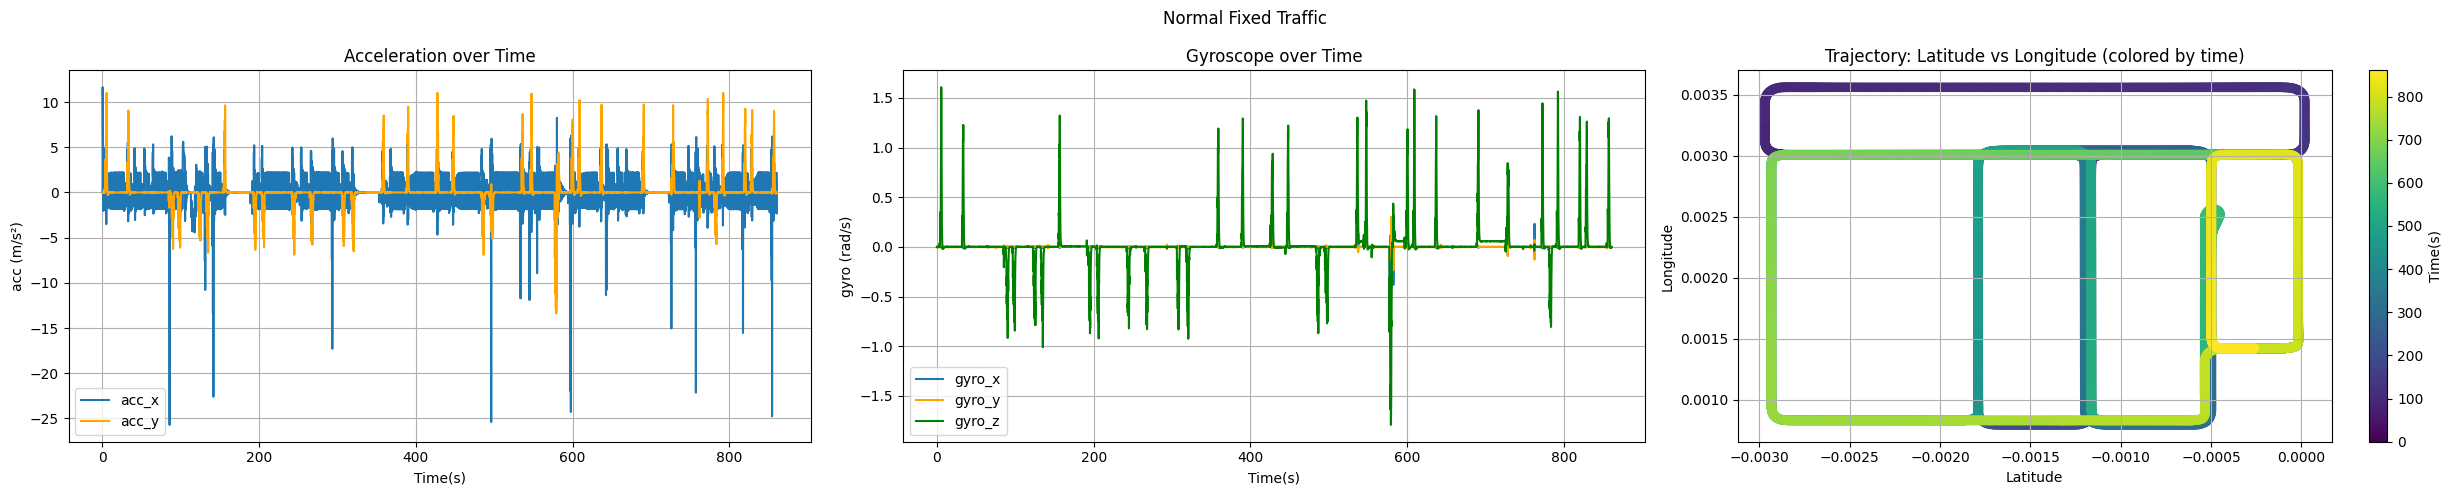

Figure saved to ../results/figures/carla/Town01/normal_llm.png


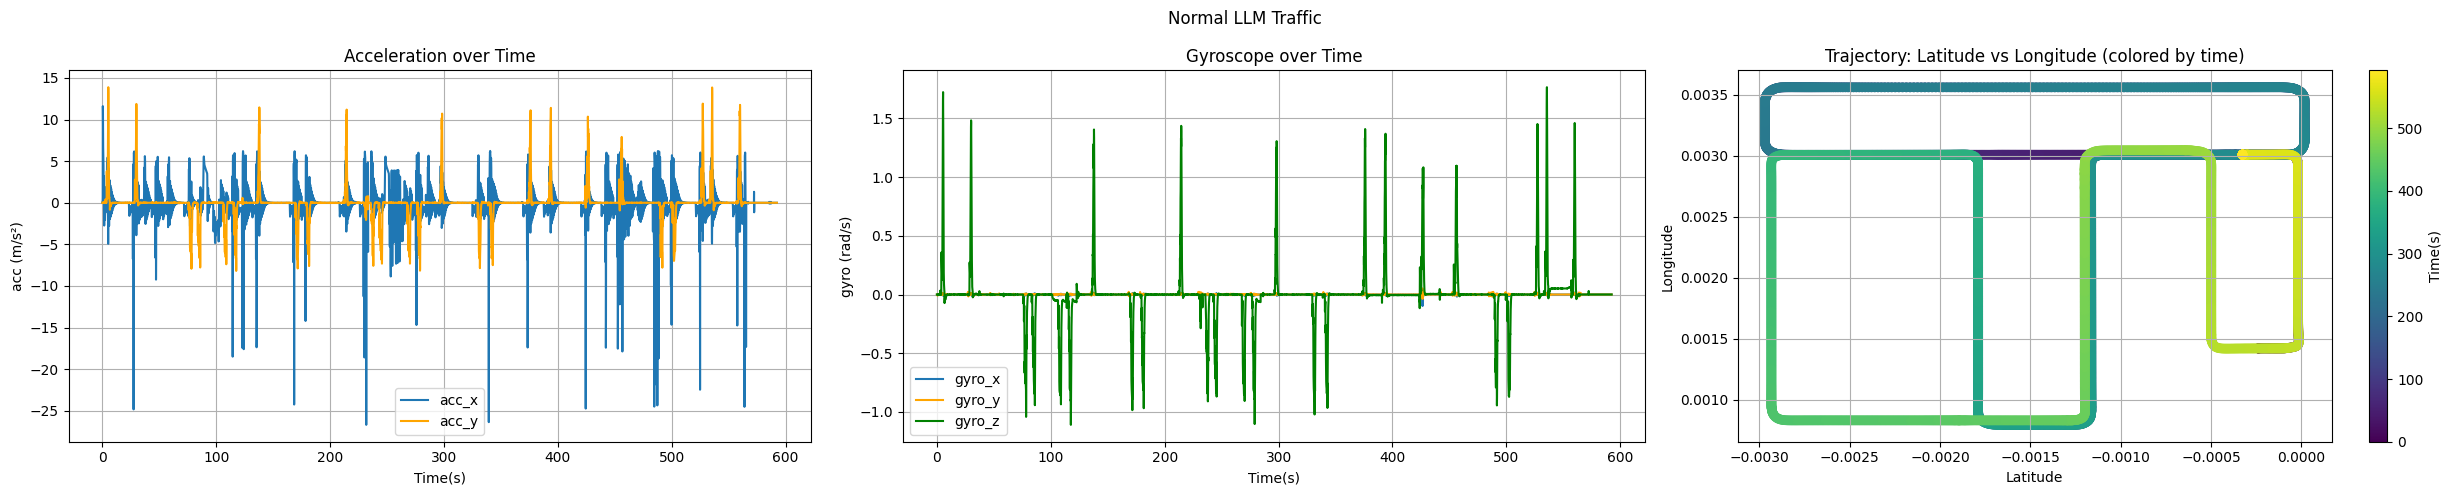

In [15]:
data_path = f"../data/synthetic/{town}/carla"
df_aggressive_fixed_traffic = pd.read_csv(f"{data_path}/fixed/traffic/veh_0_aggressive.csv")
df_aggressive_llm_traffic = pd.read_csv(f"{data_path}/llm/traffic/veh_0_aggressive.csv")
df_normal_fixed_traffic = pd.read_csv(f"{data_path}/fixed/traffic/veh_0_normal.csv")
df_normal_llm_traffic = pd.read_csv(f"{data_path}/llm/traffic/veh_0_normal.csv")

figs_path = f"../results/figures/carla/{town}"
plot_df(df_aggressive_fixed_traffic, title="Aggressive Fixed Traffic", output_path=f"{figs_path}/aggressive_fixed.png")
plot_df(df_aggressive_llm_traffic, title="Aggressive LLM Traffic", output_path=f"{figs_path}/aggressive_llm.png")
plot_df(df_normal_fixed_traffic, title="Normal Fixed Traffic", output_path=f"{figs_path}/normal_fixed.png")
plot_df(df_normal_llm_traffic, title="Normal LLM Traffic", output_path=f"{figs_path}/normal_llm.png")